In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

Let's create a vector containing the price for placing a bid at each node of an auction lot.

In [3]:
pricing = np.arange(1, 101)
pricing

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

We will use `pricing` in conjunction with a player's `strategy` to determine each player's next bids. A strategy is a vector of 0s and 1s that determins the next bid positions for a player. By defining it like so, we could utilize evolutionary genetic algorithms easily. We can cross 2 strategies together, by taking half of one and half of another to produce an offspring. We can also mutate easily, by randomly taking an index and changing it from 0 to 1 or vice-versa.


In [4]:
strategy = np.zeros(100, dtype=int)
strategy[0] = 1 # player would like to bid to node 0 [price = 1]

# player would like to bid
# until node 50 [price = 51],
# incrementing each time by 10
strategy[0:51:10] = 1

strategy[-1] = 1 # player would like to bid to node 99 [price = 100]

strategy

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

By multiplying the strategy and pricing vectors we can extract the nodes that the user would like to end at. Additionaly, removing all zero-elements will improve computation speed.

In [5]:
bids = strategy * pricing
bids = bids[bids > 0]

bids

array([  1,  11,  21,  31,  41,  51, 100])

We can easily convert from bids to strategy and vice-versa, so we might as well define some helper function for those purposes.

We will convert bids and strategies and vice-versa often, so we might as well define some helper functions to do so.


In [6]:
def strategy_to_bids(strategy):
  bids = strategy * pricing
  bids = bids[bids > 0]

  return bids

def bids_to_strategy(bids):
  strategy = np.zeros(100, dtype=int)
  strategy[bids - 1] = 1

  return strategy

Based on the current bid, we can see if the player would like to raise to a higher bid by doing so

In [7]:
current_bid = 50 

next_bid = np.min(bids[bids > current_bid], initial=404)

next_bid

51

If there isn't a bid higher than the current bid, the np.min function will return 404 (initial=404). This is a way to handle the case where the player doens't any higher response bids left.

In [8]:
current_bid = 100

# return next_bid in the sequence, 
# if none is found return 404
next_bid = np.min(bids[bids > current_bid], initial=404)

next_bid

404

Let's define a `Player` class for our game. Each player would have an id, strategy, balance and a method for retrieving his next bid.

In [9]:
class Player:
  def __init__(self, id, strategy, balance):
    self.id = id
    self.balance = balance
    self.strategy = strategy
    self.bids = strategy_to_bids(strategy)

  def get_next_bid(self, lot):
    # Don't bid agains yourself
    if lot.current_bid_owner is not None and self.id == lot.current_bid_owner.id:
      return None

    bids = self.bids

    next_bid = np.min(
      bids[bids > lot.current_bid],
      initial=404
    )

    # Ceiling reached
    if next_bid == 404:
      return None
    
    # Not enough in balance to cover
    if self.balance < next_bid:
      return None
    
    return next_bid

Let's define a `HundredVoteLot`. A lot is a single rounds of our game. Each lot places 100 votes for auction, and players utilize their strategies to win the 100 votes.

In [10]:
class HundredVoteLot:
  current_bid = 0
  current_bid_owner: Player = None

  def __init__(self, players: list[Player]):
    self.players = random.sample(players, len(players))

  def run(self):
    self.history = []

    abstain_counter = 0

    while abstain_counter < len(self.players):
      for player in self.players:
        next_bid = player.get_next_bid(self)

        if next_bid is None:
          abstain_counter += 1
        else:
          abstain_counter = 0
          self.current_bid = next_bid
          self.current_bid_owner = player

          player.balance -= next_bid
        
        self.history.append((player.id, next_bid))
    
    if self.current_bid_owner is not None:
      self.current_bid_owner.balance += 100

Let's define an example strategy and then run a lot of 2 players utilizing the same strategy. 

In [11]:
example_strategy = bids_to_strategy(np.array([1, 25, 50]))

print("Players will bid to", strategy_to_bids(example_strategy))

Players will bid to [ 1 25 50]


In [12]:
players = [
  Player("Alice", example_strategy, balance=1000),
  Player("Bob", example_strategy, balance=1000),
]

lot = HundredVoteLot(players)
lot.run()

print(f"{len(players)} players play for 100 votes...")
print(f"History [(player.id, player.bid)]: \n{lot.history}")

for player in players:
  print(f"{player.id} has a balance of {player.balance} votes")

2 players play for 100 votes...
History [(player.id, player.bid)]: 
[('Bob', 1), ('Alice', 25), ('Bob', 50), ('Alice', None), ('Bob', None), ('Alice', None)]
Alice has a balance of 975 votes
Bob has a balance of 1049 votes


Let's define our game - `HundredVoteAuction`. A HundredVoteAuction is a repeating HundredVoteLot, where the each players balance gets persisted to the next lot.

In [13]:
class HundredVoteAuction:
  def __init__(self, players: list[Player], lots: int):
    self.players = players
    self.lots = lots
    self.history = []
    self.balances = np.zeros((len(players), lots + 1))

  def run(self):
    self.balances[:, 0] = [player.balance for player in players]

    for lot_number in range(1, self.lots + 1):
      lot = HundredVoteLot(self.players)
      lot.run()

      self.history.append(lot.history)

      for i, player in enumerate(self.players):
        self.balances[i][lot_number] = player.balance

  def plot(self):
    for i, player in enumerate(self.players):
      plt.plot(self.balances[i], label=f'{player.id}')
    
    plt.xlabel('Game #')
    plt.ylabel('Player\'s Balance')
    plt.legend()
    plt.show()

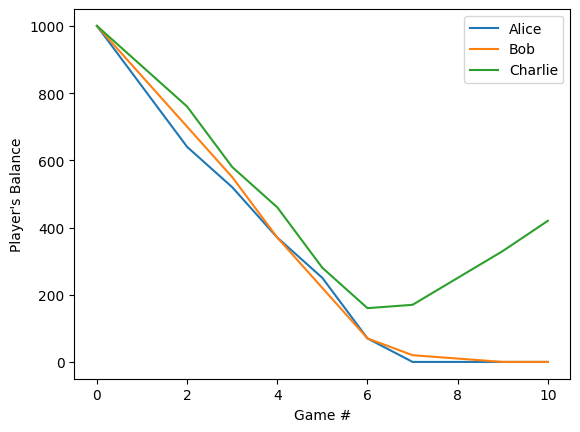

In [14]:
# Start at 10 (9+1),
# incrementing by 10 each time
# until the end (100)
example_strategy= np.zeros(100)
example_strategy[9::10] = 1

players = [
  Player("Alice", example_strategy, balance=1000),
  Player("Bob", example_strategy, balance=1000),
  Player("Charlie", example_strategy, balance=1000),
]

auction = HundredVoteAuction(players, lots=10)
auction.run()
auction.plot()

Let's run a couple of simulation to determine what type of strategy get's ahead, by changing only one variable at a time (balance, ceiling, increment)

### Increment (Bid Delta)

Assumption - if all players have the same ceiling, then the player with the least steps to get to that ceiling has an advantage. This would be the player with the highest increment. This comes from the design of the game which requires each placed bid to be payed immediately. Larger increments get you to that target ceiling with a lower investment.

In [31]:
bids_5 = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ])
bids_10 = np.array([1, 10, 20, 30, 40, 50, ])
bids_25= np.array([1, 25, 50])

bids_5 = np.arange(0, 101, 5)
bids_5[0] = 1

bids_10 = np.arange(0, 101, 10)
bids_10[0] = 1

bids_25 = np.arange(0, 101, 25)
bids_25[0] = 1

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

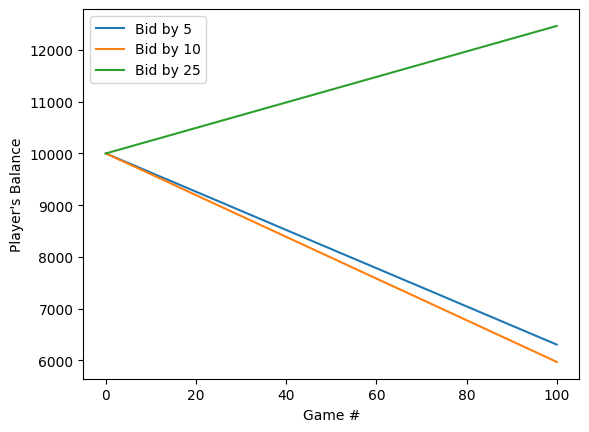

In [16]:
SIMULATIONS = 1000
LOTS_PER_AUCTION = 100

data = np.zeros((SIMULATIONS, 3, LOTS_PER_AUCTION + 1))

for i in range(SIMULATIONS):
  players = [
    Player("Bid by 5", bids_to_strategy(bids_5), balance=10000),
    Player("Bid by 10", bids_to_strategy(bids_10), balance=10000),
    Player("Bid by 25", bids_to_strategy(bids_25), balance=10000),
  ]

  auction = HundredVoteAuction(players, lots=LOTS_PER_AUCTION)
  auction.run()

  data[i] = auction.balances

averages = np.zeros((4, LOTS_PER_AUCTION + 1))
averages = np.mean(data, axis=0)

auction = HundredVoteAuction(players, lots=LOTS_PER_AUCTION)
auction.balances = averages
auction.plot()

### Balance

Assumption - if all players utilize the exact same strategy, then the player with the highest balance would come ontop, because it can compete with other players for more lots, when others slowly run out of votes.

In [17]:
random_strategy = np.random.randint(0, 2, 100) 

random_strategy

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1])

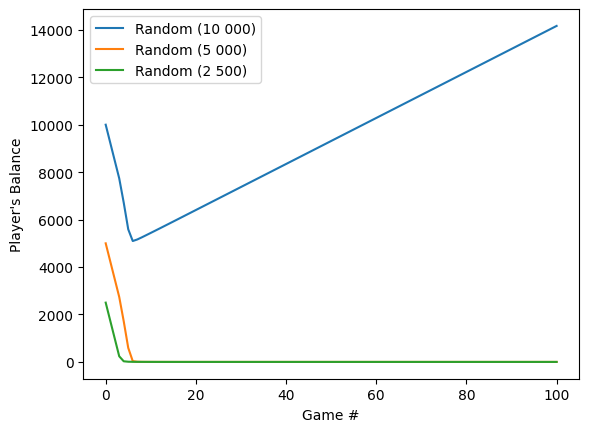

In [18]:
SIMULATIONS = 1000
LOTS_PER_AUCTION = 100

data = np.zeros((SIMULATIONS, 3, LOTS_PER_AUCTION + 1))

for i in range(SIMULATIONS):
  players = [
    Player("Random (10 000)", random_strategy, balance=10000),
    Player("Random (5 000)", random_strategy, balance=5000),
    Player("Random (2 500)", random_strategy, balance=2500),
  ]

  auction = HundredVoteAuction(players, lots=LOTS_PER_AUCTION)
  auction.run()

  data[i] = auction.balances

averages = np.zeros((3, LOTS_PER_AUCTION + 1))
averages = np.mean(data, axis=0)

auction = HundredVoteAuction(players, lots=LOTS_PER_AUCTION)
auction.balances = averages
auction.plot()

### Ceiling (Last bid location)

Assumption - the player with the highest bid will always win the lot, so by keeping the increment the same for all players, the player with the highest ceiling will always come ontop.

In [19]:
ceiling_50 = np.zeros(100)
ceiling_50[9:50:10] = 1

ceiling_70 = np.zeros(100)
ceiling_70[9:70:10] = 1

ceiling_90 = np.zeros(100)
ceiling_90[9:90:10] = 1

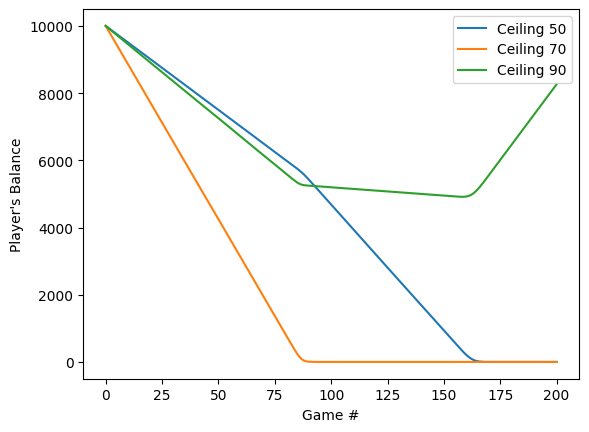

In [20]:
SIMULATIONS = 1000
LOTS_PER_AUCTION = 200

data = np.zeros((SIMULATIONS, 3, LOTS_PER_AUCTION + 1))

for i in range(SIMULATIONS):
  players = [
    Player("Ceiling 50", ceiling_50, balance=10000),
    Player("Ceiling 70", ceiling_70, balance=10000),
    Player("Ceiling 90", ceiling_90, balance=10000),
  ]

  auction = HundredVoteAuction(players, lots=LOTS_PER_AUCTION)
  auction.run()

  data[i] = auction.balances

averages = np.zeros((3, LOTS_PER_AUCTION + 1))
averages = np.mean(data, axis=0)

auction = HundredVoteAuction(players, lots=LOTS_PER_AUCTION)
auction.balances = averages
auction.plot()

### Evolutionary Battles

Let's define a bunch of strategies to compare.

In [21]:
S0 = np.zeros(100).astype(int)
S0[0] = 1
S0[-1] = 1

S1 = np.zeros(100).astype(int)
S1[0] = 1
S1[9::10] = 1

S2 = np.zeros(100).astype(int)
S2[0] = 1
S2[24::25] = 1

S3 = np.zeros(100).astype(int)
S3[0] = 1
S3[32::33] = 1

The `create_population` function will accept a list of strategies and a replication amount. It will return an array containing each strategy as many times as the replication amount is.

strategies [S1, S2] -> create_population(strategies, 3) -> population [S1, S1, S1, S2, S2, S2]

In [22]:
def create_population(strategies, replication=5):
  population = np.zeros((len(strategies) * replication, 100))

  for i, strategy in enumerate(strategies):
    for r in range(replication):
      population[i * replication + r] = strategy

  return population

Let's define a function that counts the occurence of each strategy in a given population.

In [23]:
def strategy_occurrence(population, strategy):
  return np.sum(np.all(population == strategy, axis=1))

In [24]:
strategies = [S0, S1, S2, S3]
strategy_names = ["S0", "S1", "S2", "S3"]
population = create_population(strategies, replication=5)

for strategy, name in zip(strategies, strategy_names):
  print(name, strategy_occurrence(population, strategy))

S0 5
S1 5
S2 5
S3 5


In [25]:
def sample_population(population, sample_size):
  indexes = np.random.choice(len(population), sample_size, replace=False)

  return indexes, population[indexes]

In [26]:
battle_indexes, battle_strategies = sample_population(population, 2)

battle_indexes, battle_strategies

(array([19,  2]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1.]]))

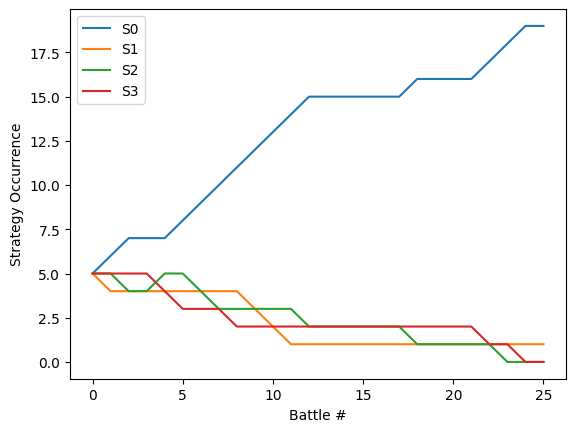

In [27]:
BATTLES = 25
ROUNDS_PER_BATTLE = 100
STARTING_BALANCE = 1000

strategies = [S0, S1, S2, S3]
strategy_names = ['S0', 'S1', 'S2', 'S3']
population = create_population(strategies, replication=5)

data = np.ndarray((BATTLES + 1, len(strategies)))

for battle_index in range(BATTLES):
  for strategy_index, strategy in enumerate(strategies):
    data[battle_index][strategy_index] = strategy_occurrence(population, strategy)

  battle_indexes, battle_strategies = sample_population(population, 2)

  players = [
    Player(0, battle_strategies[0], balance=STARTING_BALANCE),
    Player(1, battle_strategies[1], balance=STARTING_BALANCE),
  ]

  auction = HundredVoteAuction(
    players=players,
    lots=ROUNDS_PER_BATTLE
  )

  auction.run()

  # replace loosing strategy with the winning one
  if players[0].balance > players[1].balance:
    population[battle_indexes[1]] = population[battle_indexes[0]]
  else:
    population[battle_indexes[0]] = population[battle_indexes[1]]

for strategy_index, strategy in enumerate(strategies):
  data[BATTLES][strategy_index] = strategy_occurrence(population, strategy)

plt.plot(data, label=strategy_names)
plt.xlabel('Battle #')
plt.ylabel('Strategy Occurrence')
plt.legend()
plt.show()

In [28]:
BATTLES = 50

def fitness(population, strategies):
  unique_strategy_count = len(strategies)
  data = np.ndarray((BATTLES + 1, len(unique_strategy_count)))

  for battle_index in range(BATTLES):
    for strategy_index, strategy in enumerate(strategies):
      data[battle_index][strategy_index] = strategy_occurrence(population, strategy)

    battle = random.sample(list(enumerate(population)), 2)

    players = [
      Player(f"Strategy {battle[0][0]}", battle[0][1], balance=STARTING_BALANCE),
      Player(f"Strategy {battle[1][0]}", battle[1][1], balance=STARTING_BALANCE),
    ]

    auction = HundredVoteAuction(
      players=players,
      lots=ROUNDS_PER_BATTLE
    )


In [29]:
def unique_strategies(population):
  strategy, count = np.unique(population, return_counts=True, axis=0)

  return strategy, count

In [30]:
population = create_population([S0, S1, S2, S3], replication=5)
strategies, counts = unique_strategies(population)

for strategy, count in zip(strategies, counts):
  print(strategy_to_bids(strategy), count)

[  1. 100.] 5
[ 1. 33. 66. 99.] 5
[  1.  25.  50.  75. 100.] 5
[  1.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.] 5
